<a href="https://colab.research.google.com/github/Beebruna/Treinamento_Data_Science/blob/main/Image_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip3 install --upgrade tensorflow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Superviside learning <p>
Image Classification <p>
CNN


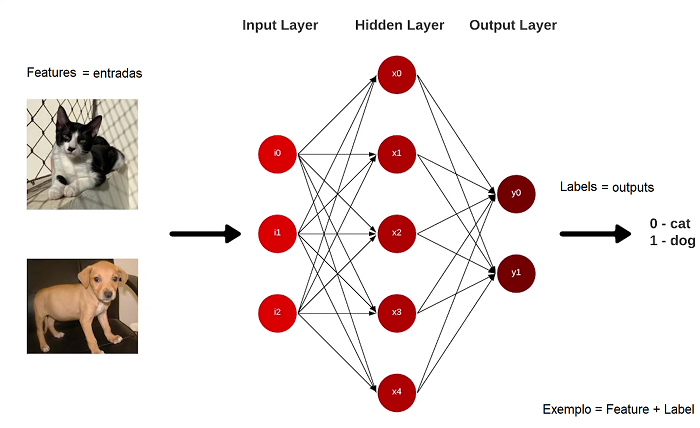

In [2]:
import os
import tensorflow as tf
import matplotlib.pyplot as plt

In [ ]:
!wget https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip

In [4]:
!unzip cats_and_dogs_filtered.zip

Archive:  cats_and_dogs_filtered.zip
replace cats_and_dogs_filtered/vectorize.py? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [5]:
!rm -rf cats_and_dogs_filtered.zip

In [48]:
dataset_dir = os.path.join(os.getcwd(), 'cats_and_dogs_filtered')

In [8]:
dataset_dir

'/content/cats_and_dogs_filtered'

In [49]:
dataset_train_dir = os.path.join(dataset_dir, 'train')
dataset_train_cats_len = len(os.listdir(os.path.join(dataset_train_dir, 'cats')))
dataset_train_dogs_len = len(os.listdir(os.path.join(dataset_train_dir, 'dogs')))

In [50]:
dataset_validation_dir = os.path.join(dataset_dir, 'validation')
dataset_validation_cats_len = len(os.listdir(os.path.join(dataset_validation_dir, 'cats')))
dataset_validation_dogs_len = len(os.listdir(os.path.join(dataset_validation_dir, 'dogs')))

In [51]:
print('Train Cats: ', dataset_train_cats_len)
print('Train Dogs: ', dataset_train_dogs_len)
print('Validation Cats: ', dataset_validation_cats_len)
print('Validation Dogs: ', dataset_validation_dogs_len)

Train Cats:  1000
Train Dogs:  1000
Validation Cats:  500
Validation Dogs:  500


Converter as imagens para o tamanho 160x160

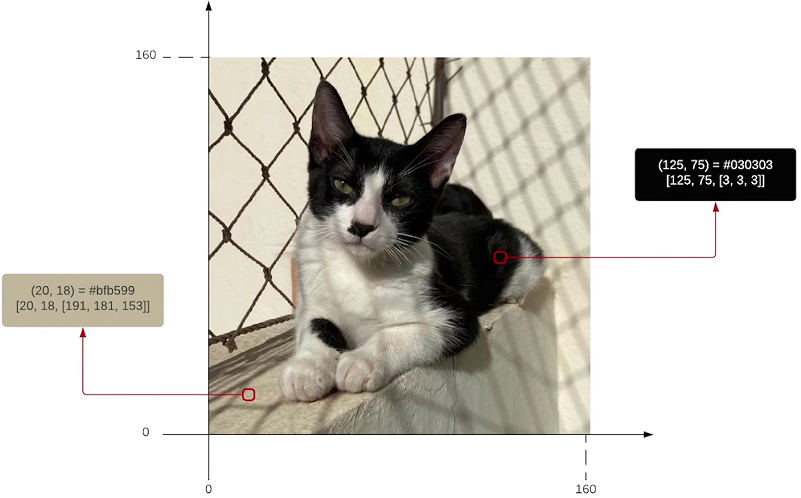

In [52]:
image_width = 160
image_height = 160
image_color_channel = 3
image_color_channel_size = 255
image_size = (image_width, image_height)
image_shape = image_size + (image_color_channel,)

In [53]:
batch_size = 32 #quantidade de features do dataset, por vez
epochs = 20 #Número de vezes em que o dataset será consultado/percorrido
learning_rate = 0.0001
class_names = ['cat', 'dog']

In [54]:
dataset_train = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_train_dir,
    image_size = image_size,
    batch_size = batch_size,
    shuffle = True
)

Found 2000 files belonging to 2 classes.


In [55]:
dataset_validation = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_validation_dir,
    image_size = image_size,
    batch_size = batch_size,
    shuffle = True
)

Found 1000 files belonging to 2 classes.


In [56]:
dataset_validation_cardinality = tf.data.experimental.cardinality(dataset_validation) # 1000 / 32
dataset_validation_batches = dataset_validation_cardinality // 5

dataset_test = dataset_validation.take(dataset_validation_batches)
dataset_validation = dataset_validation.skip(dataset_validation_batches)

print('Validation Dataset Cardinality: ', tf.data.experimental.cardinality(dataset_validation))
print('Test Dataset Cardinality: ', tf.data.experimental.cardinality(dataset_test))

Validation Dataset Cardinality:  tf.Tensor(26, shape=(), dtype=int64)
Test Dataset Cardinality:  tf.Tensor(6, shape=(), dtype=int64)


Dataset treino -> atualiza os parâmetros <p>
Dataset validação -> valida o modelo durante o treinameto, mas não modifica os parâmetros. <p>
Dataset teste -> testa o modelo.

In [57]:
def plot_dataset(dataset):

    plt.gcf().clear()
    plt.figure(figsize = (15, 25))

    for features, labels in dataset.take(1):

        for i in range(9):

            plt.subplot(3, 3, i + 1)
            plt.axis('off')

            plt.imshow(features[i].numpy().astype('uint8'))
            plt.title(class_names[labels[i]])

<Figure size 432x288 with 0 Axes>

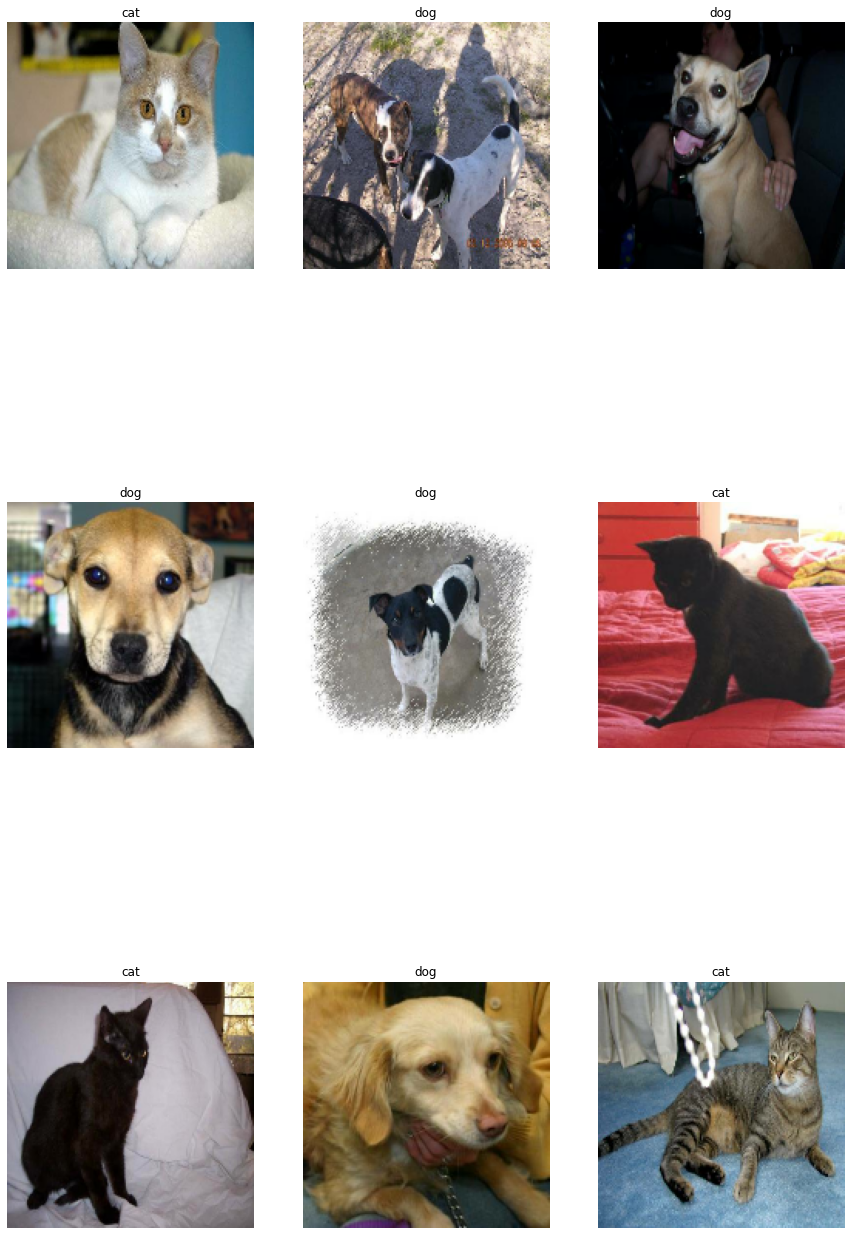

In [18]:
plot_dataset(dataset_train)

<Figure size 432x288 with 0 Axes>

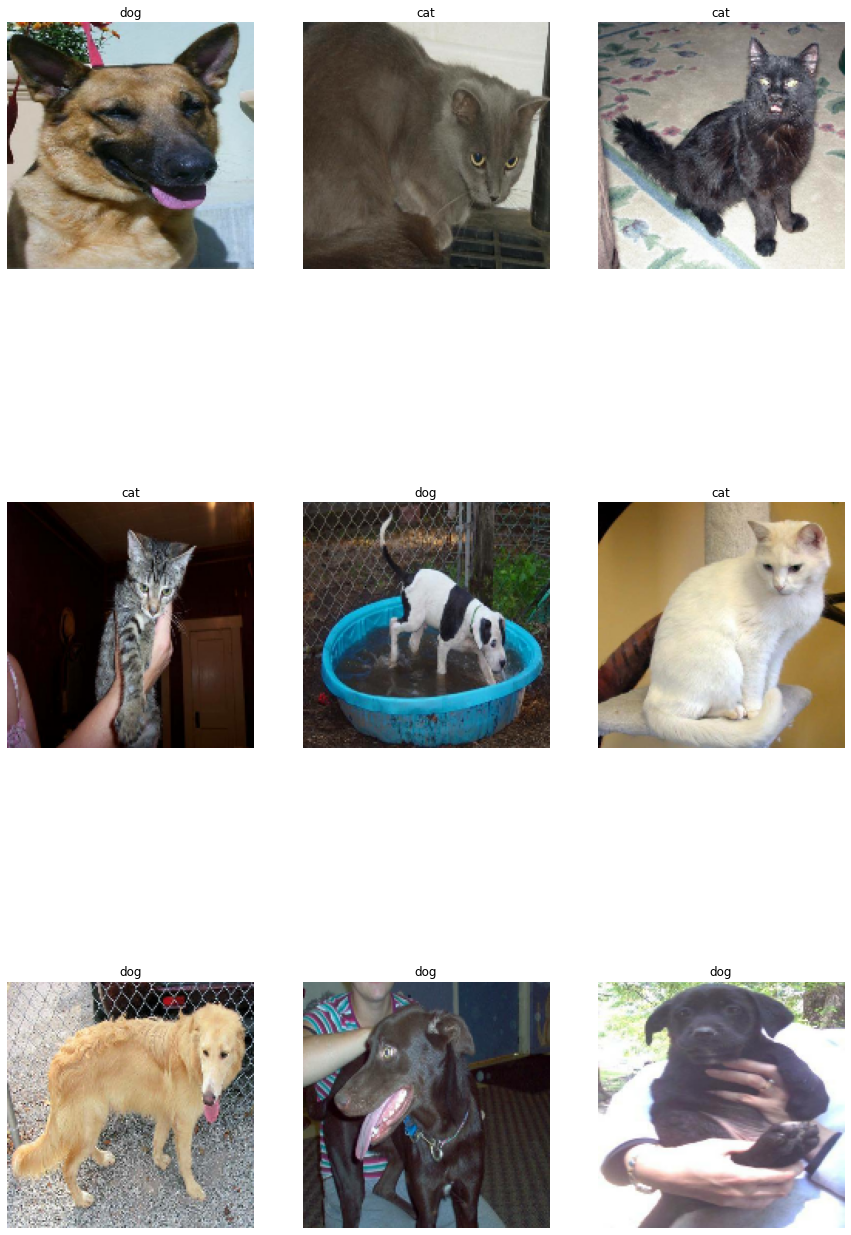

In [19]:
plot_dataset(dataset_validation)

<Figure size 432x288 with 0 Axes>

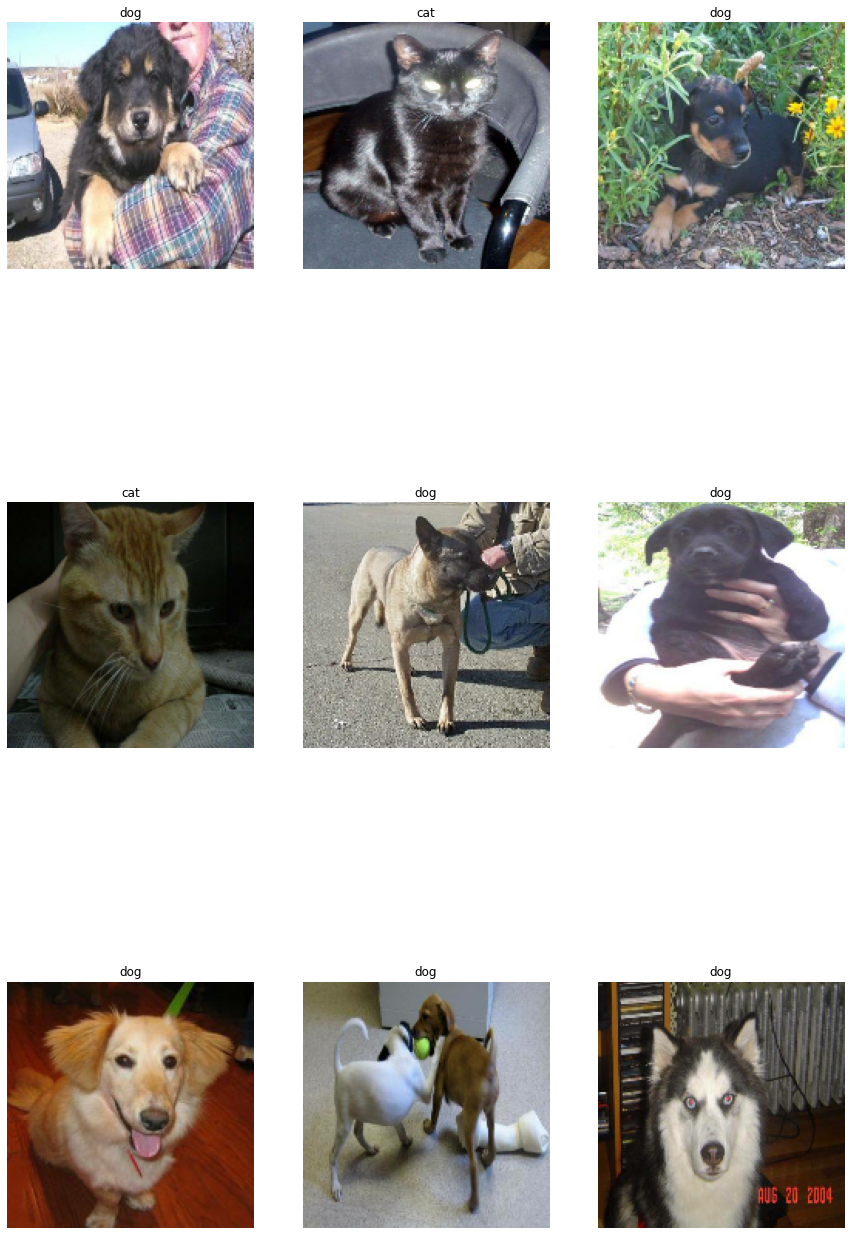

In [20]:
plot_dataset(dataset_test)

In [64]:
data_augmentation = tf.keras.models.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
    tf.keras.layers.experimental.preprocessing.RandomZoom(0.2)
])

In [65]:
def plot_dataset_data_augmentation(dataset):

    plt.gcf().clear()
    plt.figure(figsize= (15, 15))

    for features, _ in dataset.take(1):
        feature = features[0]

        for i in range(9):
            feature_data_augmentation = data_augmentation(tf.expand_dims(feature, 0))

            plt.subplot(3, 3, i + 1)
            plt.axis('off')

            plt.imshow(feature_data_augmentation[0] / image_color_channel_size)

<Figure size 432x288 with 0 Axes>

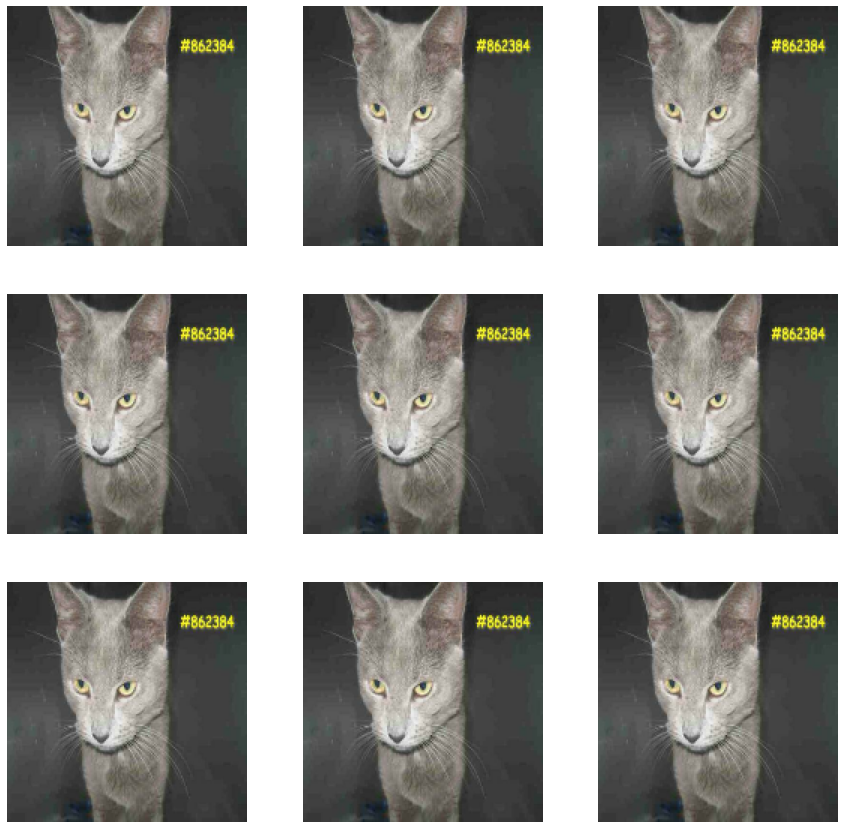

In [69]:
plot_dataset_data_augmentation(dataset_train)

In [72]:
model_transfer_learning = tf.keras.applications.MobileNetV2(
    input_shape = image_shape,
    include_top = False,
    weights = 'imagenet'
)

model_transfer_learning.trainable = False
model_transfer_learning.summary()

9406464/9406464 [==============================] - 0s 0us/step
Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 80, 80, 32)   864         ['input_1[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 80, 80, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReL

Convolução

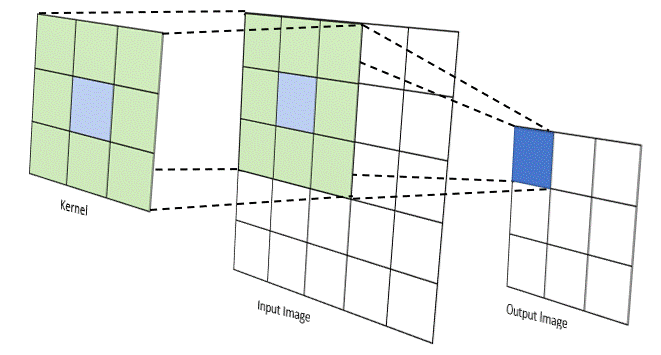

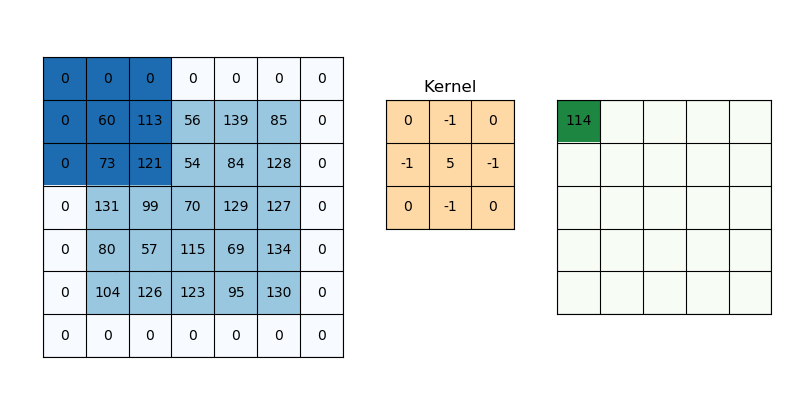

Sequencial = uma camada após a outra <p>
1º camada: 160x160x3 e normalização [0,255] -> [0,1]<p>
2º camada: tamanho 16, passa o kernel(tamanho = 3) 16 vezes
* padding = adiciona a borda de zeros

In [59]:
model = tf.keras.models.Sequential([
        tf.keras.layers.Rescaling(1. / image_color_channel_size, input_shape = image_shape),
        tf.keras.layers.Conv2D(16, 3, padding= 'same', activation= 'relu'),
        tf.keras.layers.MaxPool2D(),
        tf.keras.layers.Conv2D(32, 3, padding= 'same', activation= 'relu'),
        tf.keras.layers.MaxPool2D(),
        tf.keras.layers.Conv2D(64, 3, padding= 'same', activation= 'relu'),
        tf.keras.layers.MaxPool2D(),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation= 'relu'),
        tf.keras.layers.Dense(1, activation= 'sigmoid')
])

solução do overftting

In [75]:
model2 = tf.keras.models.Sequential([
        tf.keras.layers.Rescaling(1. / (image_color_channel_size / 2), offset= -1, input_shape = image_shape),
        data_augmentation,
        model_transfer_learning,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(1, activation= 'sigmoid')
])

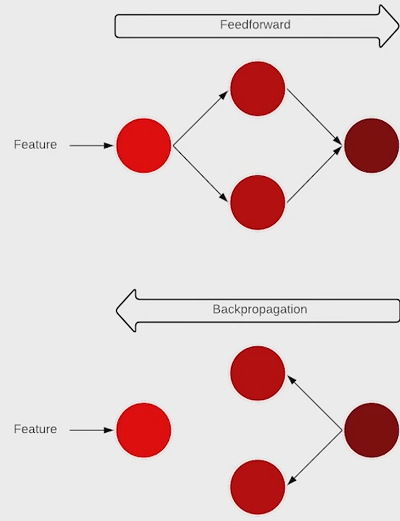

In [29]:
model.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate = learning_rate),
    loss = tf.keras.losses.BinaryCrossentropy(),
    metrics = ['accuracy']
)

In [76]:
model2.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate = learning_rate),
    loss = tf.keras.losses.BinaryCrossentropy(),
    metrics = ['accuracy']
)

In [30]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 160, 160, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 160, 160, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 80, 80, 16)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 80, 80, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 40, 40, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 40, 40, 64)       

In [77]:
model2.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_10 (Rescaling)    (None, 160, 160, 3)       0         
                                                                 
 sequential_11 (Sequential)  (None, 160, 160, 3)       0         
                                                                 
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d_1   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_7 (Dropout)         (None, 1280)              0         
                                                                 
 dense_19 (Dense)            (None, 1)               

25m24s

In [31]:
history = model.fit(
    dataset_train,
    validation_data = dataset_validation,
    epochs = epochs
)

Epoch 1/20
63/63 [==============================] - 68s 1s/step - loss: 0.6901 - accuracy: 0.5210 - val_loss: 0.6675 - val_accuracy: 0.6819
Epoch 2/20
63/63 [==============================] - 61s 970ms/step - loss: 0.6478 - accuracy: 0.6255 - val_loss: 0.6153 - val_accuracy: 0.6485
Epoch 3/20
63/63 [==============================] - 64s 1s/step - loss: 0.6035 - accuracy: 0.6820 - val_loss: 0.5920 - val_accuracy: 0.6980
Epoch 4/20
63/63 [==============================] - 65s 1s/step - loss: 0.5638 - accuracy: 0.7200 - val_loss: 0.5753 - val_accuracy: 0.6955
Epoch 5/20
63/63 [==============================] - 63s 1s/step - loss: 0.5532 - accuracy: 0.7310 - val_loss: 0.5628 - val_accuracy: 0.7215
Epoch 6/20
63/63 [==============================] - 60s 953ms/step - loss: 0.5346 - accuracy: 0.7310 - val_loss: 0.5824 - val_accuracy: 0.6844
Epoch 7/20
63/63 [==============================] - 63s 998ms/step - loss: 0.5058 - accuracy: 0.7560 - val_loss: 0.5659 - val_accuracy: 0.7017
Epoch 8/20


25m29s

In [78]:
history = model2.fit(
    dataset_train,
    validation_data = dataset_validation,
    epochs = epochs
)

Epoch 1/20


63/63 [==============================] - 65s 920ms/step - loss: 0.8479 - accuracy: 0.5150 - val_loss: 0.6301 - val_accuracy: 0.6498
Epoch 2/20
63/63 [==============================] - 57s 910ms/step - loss: 0.6200 - accuracy: 0.6655 - val_loss: 0.4610 - val_accuracy: 0.8267
Epoch 3/20
63/63 [==============================] - 60s 953ms/step - loss: 0.4873 - accuracy: 0.7735 - val_loss: 0.3614 - val_accuracy: 0.9035
Epoch 4/20
63/63 [==============================] - 60s 950ms/step - loss: 0.4141 - accuracy: 0.8310 - val_loss: 0.2990 - val_accuracy: 0.9183
Epoch 5/20
63/63 [==============================] - 58s 912ms/step - loss: 0.3553 - accuracy: 0.8550 - val_loss: 0.2500 - val_accuracy: 0.9356
Epoch 6/20
63/63 [==============================] - 60s 956ms/step - loss: 0.3372 - accuracy: 0.8560 - val_loss: 0.2150 - val_accuracy: 0.9517
Epoch 7/20
63/63 [==============================] - 64s 1s/step - loss: 0.3011 - accuracy: 0.8750 - val_loss: 0.1912 - val_accuracy: 0.9579
Epoch 8/20
63

In [33]:
def plot_dataset_predictions(dataset):

    features, labels = dataset.as_numpy_iterator().next()

    predictions = model.predict_on_batch(features).flatten()
    predictions = tf.where(predictions < 0.5, 0, 1)

    print('Labels:     ', labels)
    print('Predictions:', predictions.numpy())

    plt.gcf().clear()
    plt.figure(figsize= (15, 15))

    for i in range(9):

        plt.subplot(3, 3, i + 1)
        plt.axis('off')

        plt.imshow(features[i].astype('uint8'))
        plt.title(class_names[predictions[i]])

Labels:      [1 0 0 0 1 1 1 0 0 0 1 0 0 1 0 1 0 1 0 0 1 1 1 0 0 0 0 0 0 0 0 0]
Predictions: [0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0]


<Figure size 432x288 with 0 Axes>

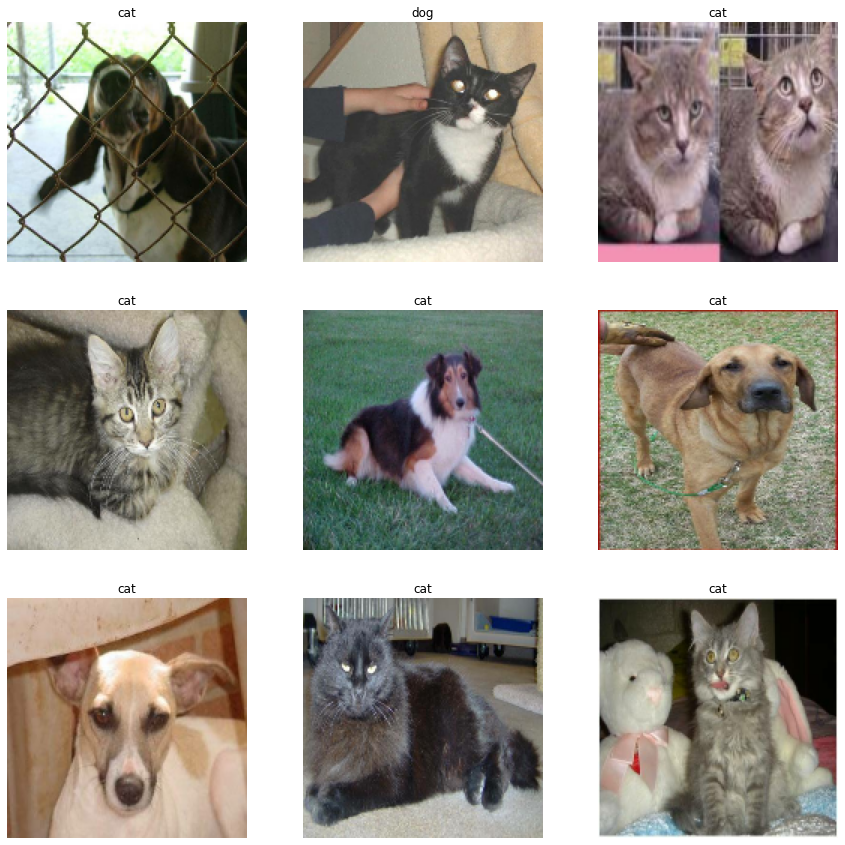

In [81]:
plot_dataset_predictions(dataset_test)

In [ ]:
model.save('<path>')

In [ ]:
model = tf.keras.models.load_model('<path>')

Análise do Modelo

In [79]:
def plot_model():

    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(epochs)

    plt.gcf().clear()
    plt.figure(figsize= (15, 8))

    plt.subplot(1, 2, 1)
    plt.title('Training and Validation Accuracy')
    plt.plot(epochs_range, accuracy, label= 'Training Accuracy')
    plt.plot(epochs_range, val_accuracy, label= 'Validation Accuracy')
    plt.legend(loc= 'lower right')

    plt.subplot(1, 2, 2)
    plt.title('Training and Validation Loss')
    plt.plot(epochs_range, loss, label= 'Training Loss')
    plt.plot(epochs_range, val_loss, label= 'Validation Loss')
    plt.legend(loc= 'lower right')

    plt.show()

Overfitting

<Figure size 432x288 with 0 Axes>

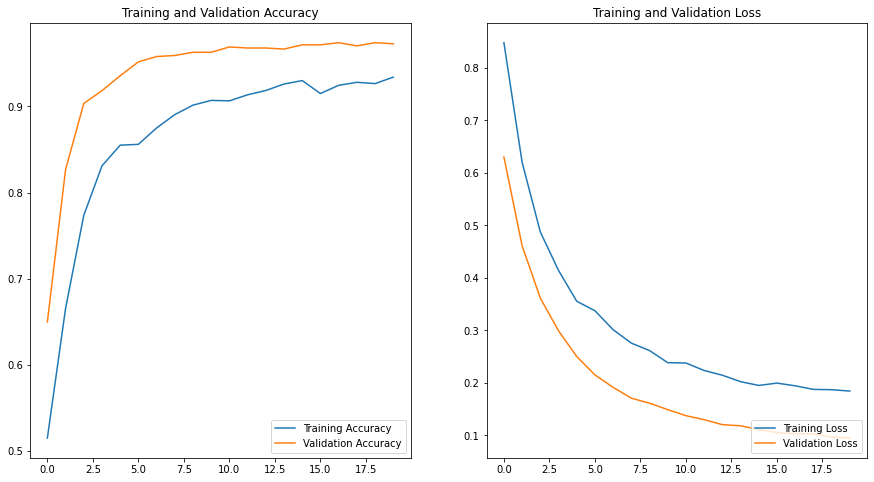

In [80]:
plot_model()

overfitting: modelo treina muito bem e tem performance boa no dataset de treinamento, mas a performance é ruim para features nunca vistas <p>
Solução para overfitting: aumentar a quantidade de nós das camadas convolucionais e das Dense layers.